# Experiment 1: Six different depths of models, trained on 5 of the 6 subjects then evaluated on the 6th. 

*   0 degree aspect angle
*   Models:
    *  2-4
    *  4-8
    *  8-16
    *  16-32
    *  32-64
    *  64-128
  




## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    FILE_PATH = '/content/gdrive/My Drive/Level-4-Project/data/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
else:
    FILE_PATH = "C:/Users/macka/Google Drive/Level-4-Project/data/"
    
from src.models.original_models import cnn_various_depths
from src.data import load_data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Found existing installation: src 0.1.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from six.moves import cPickle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [0]:
batch_size = 100
nb_classes = 7
nb_epoch = 20
nb_epoch = 3 # originally 100
data_augmentation = False
nb_train_samples = 35595

# input image dimensions
img_rows, img_cols = 75, 75
# the CIFAR10 images are RGB


# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = load_data.load_data((FILE_PATH + 'cifar_initialised'), nb_train_samples)

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255 

models = {"2-4": {}, "4-8": {}, "8-16": {}, "16-32": {}, "32-64": {}, "64-128": {}}
for name, model in models.items():
    model["model"] = cnn_various_depths.make_model(name, img_rows, img_cols, nb_classes)


## Training and Evaluating Models

In [23]:
for name, model_data in models.items():
    # let's train the model using SGD + momentum (how original).
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model_data["model"].compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    if not data_augmentation:
        print('Not using data augmentation.')
        history = model_data["model"].fit(
            X_train,
            Y_train,
            batch_size=batch_size,
            epochs=nb_epoch,
            validation_data=(X_test, Y_test),
            shuffle=True, 
            verbose=1)

        y_pred = model_data["model"].predict_classes(X_test)
        target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting', 'Walking']
        model_data["history"] = history
        model_data["classification_report"] = classification_report(np.argmax(Y_test,axis=1), y_pred,target_names=target_names)
        model_data["confusion_matrix"] = confusion_matrix(np.argmax(Y_test,axis=1), y_pred)
#         model.save('/home/aleksandar/sets/cifar_initialised/results/model_initialised.h5')

    else:
        print('Using real-time data augmentation.')

        # this will do preprocessing and realtime data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

        # compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied)
        datagen.fit(X_train)

        # fit the model on the batches generated by datagen.flow()
        hist = model.fit_generator(datagen.flow(X_train, Y_train,
                            batch_size=batch_size),
                            samples_per_epoch=X_train.shape[0],
                            nb_epoch=nb_epoch,
                            validation_data=(X_test, Y_test))

        #NEW--------------------
        y_pred = model.predict_classes(X_test)
        print(y_pred)
        target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting', 'Walking']
#         sys.stdout = open('/home/aleksandar/sets/cifar_initialised/results/report_initialised.txt', "w")
        print("CLASSIFICATION REPORT:")
        print(classification_report(np.argmax(Y_test,axis=1), y_pred,target_names=target_names))
        print ("\n")
        print("CONFUSION MATRIX:")
        print(confusion_matrix(np.argmax(Y_test,axis=1), y_pred))

#         with open('/home/aleksandar/sets/cifar_initialised/results/graphs_initialised.csv', "w") as f:
#            w = csv.writer(f)
#            train_loss = hist.history['loss']
#            val_loss = hist.history['val_loss']
#            train_acc = hist.history['acc']
#            val_acc = hist.history['val_acc']
#            helplist = list(zip(train_loss, train_acc, val_loss, val_acc))
#            w.writerow("train_loss, train_acc, val_loss, val_acc")
#            for val in helplist:
#               w.writerow([val])


#         model.save('/home/aleksandar/sets/cifar_initialised/results/model_initialised.h5')
#         #-----------------------

Not using data augmentation.
Train on 35595 samples, validate on 7119 samples
Epoch 1/3
35595/35595 [==============================] - 9s 250us/step - loss: 0.8053 - acc: 0.6910 - val_loss: 0.1516 - val_acc: 0.9628
Epoch 2/3
35595/35595 [==============================] - 7s 190us/step - loss: 0.1973 - acc: 0.9320 - val_loss: 0.0984 - val_acc: 0.9753
Epoch 3/3
35595/35595 [==============================] - 7s 190us/step - loss: 0.1326 - acc: 0.9558 - val_loss: 0.0891 - val_acc: 0.9805
Not using data augmentation.
Train on 35595 samples, validate on 7119 samples
Epoch 1/3
35595/35595 [==============================] - 10s 287us/step - loss: 0.7395 - acc: 0.7106 - val_loss: 0.1209 - val_acc: 0.9720
Epoch 2/3
35595/35595 [==============================] - 8s 237us/step - loss: 0.1306 - acc: 0.9558 - val_loss: 0.0742 - val_acc: 0.9808
Epoch 3/3
35595/35595 [==============================] - 8s 234us/step - loss: 0.0721 - acc: 0.9761 - val_loss: 0.0645 - val_acc: 0.9850
Not using data augmen

## Analysis

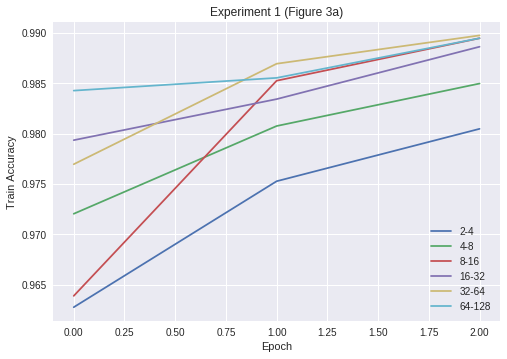

In [24]:
import matplotlib.pyplot as plt

for name, model_data in models.items():
    plt.plot(model_data["history"].history['val_acc'], label=name)
    
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Experiment 1 (Figure 3a)')
plt.show()